In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw5.ipynb")

# CPSC 330 - Applied Machine Learning 

## Homework 5: Putting it all together 
### Associated lectures: All material till lecture 13 

**Due date: Monday, October 28th, 2024 at 11:59pm**

## Table of contents
0. [Submission instructions](#si)
1. [Understanding the problem](#1)
2. [Data splitting](#2)
3. [EDA](#3)
4. [Feature engineering](#4)
5. [Preprocessing and transformations](#5) 
6. [Baseline model](#6)
7. [Linear models](#7)
8. [Different models](#8)
9. [Feature selection](#9)
10. [Hyperparameter optimization](#10)
11. [Interpretation and feature importances](#11) 
12. [Results on the test set](#12)
13. [Summary of the results](#13)
14. [Your takeaway from the course](#15)

<div class="alert alert-info">

## Submission instructions
<hr>
rubric={points:4}

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).
- If you would like to use late tokens for the homework, all group members must have the necessary late tokens available. Please note that the late tokens will be counted for all members of the group.   


Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2024W1/blob/master/docs/homework_instructions.md). 

1. Before submitting the assignment, run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Follow the [CPSC 330 homework instructions](https://ubc-cs.github.io/cpsc330-2024W1/docs/homework_instructions.html), which include information on how to do your assignment and how to submit your assignment.
4. Upload your solution on Gradescope. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
5. Make sure that the plots and output are rendered properly in your submitted file. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb so that the TAs can view your submission on Gradescope.


_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._


**SCORING: AP SCORE;
FINAL TEST SCORE: 0.57;
MODEL: HYPERTUNED LIGHTGBM**

</div>

<!-- BEGIN QUESTION -->

## Imports

<div class="alert alert-warning">
    
Imports
    
</div>

_Points:_ 0

In [2]:
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.rcParams["font.size"] = 16

from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, average_precision_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

<!-- END QUESTION -->

## Introduction <a name="in"></a>

In this homework you will be working on an open-ended mini-project, where you will put all the different things you have learned so far together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips
1. This mini-project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). Make sure you explain your decisions whenever necessary. 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 

#### Assessment
We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.


#### A final note
Finally, this style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (15-20 hours???) is a good guideline for this project . Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and I hope you enjoy it as well. 

<br><br>

<!-- BEGIN QUESTION -->

## 1. Pick your problem and explain the prediction problem <a name="1"></a>
<hr>
rubric={points:3}

In this mini project, you have the option to choose on which dataset you will be working on. The tasks you will need to carry on will be similar, independently of your choice.

### Option 1
You can choose to work on a classification problem of predicting whether a credit card client will default or not. 
For this problem, you will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. The rest of the columns can be used as features. You may take some ideas and compare your results with [the associated research paper](https://www.sciencedirect.com/science/article/pii/S0957417407006719), which is available through [the UBC library](https://www.library.ubc.ca/). 


### Option 2
You can choose to work on a regression problem using a [dataset](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data) of New York City Airbnb listings from 2019. As usual, you'll need to start by downloading the dataset, then you will try to predict `reviews_per_month`, as a proxy for the popularity of the listing. Airbnb could use this sort of model to predict how popular future listings might be before they are posted, perhaps to help guide hosts create more appealing listings. In reality they might instead use something like vacancy rate or average rating as their target, but we do not have that available here.

> Note there is an updated version of this dataset with more features available [here](http://insideairbnb.com/). The features were are using in `listings.csv.gz` for the New York city datasets. You will also see some other files like `reviews.csv.gz`. For your own interest you may want to explore the expanded dataset and try your analysis there. However, please submit your results on the dataset obtained from Kaggle.


**Your tasks:**

1. Spend some time understanding the options and pick the one you find more interesting (it may help spending some time looking at the documentation available on Kaggle for each dataset).
2. After making your choice, focus on understanding the problem and what each feature means, again using the documentation on the dataset page on Kaggle. Write a few sentences on your initial thoughts on the problem and the dataset. 
3. Download the dataset and read it as a pandas dataframe. 

<div class="alert alert-warning">
    
Solution_1
    
</div>

_Points:_ 3

_Type your answer here, replacing this text._

In [3]:
#I decided to pick Option 1, simply because predicting credit card defaults ties directly 
# into the finance and risk management sector, a high-demand field which is similar to what I'd like to work in.

cc_df = pd.read_csv("data/UCI_Credit_Card.csv", index_col='ID')

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 2. Data splitting <a name="2"></a>
<hr>
rubric={points:2}

**Your tasks:**

1. Split the data into train (70%) and test (30%) portions with `random_state=123`.

> If your computer cannot handle training on 70% training data, make the test split bigger.  

<div class="alert alert-warning">
    
Solution_2
    
</div>

_Points:_ 2

In [4]:
#splitting the data into train & test portions.
X = cc_df.drop("default.payment.next.month", axis=1)
y = cc_df["default.payment.next.month"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 3. EDA <a name="3"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

<div class="alert alert-warning">
    
Solution_3
    
</div>

_Points:_ 10

_Type your answer here, replacing this text._

In [5]:
# The range for some of the values is drastically high so scaling might be needed.
# minimum value for PAY_x columns should be -1 based on the data description but it is -2 here? 
# Might suggest "-2" values are either NaN, or something like "no payment due", etc... 
X_train.describe() 

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,...,18000.00000,18000.000000,18000.000000,18000.000000,18000.000000,1.800000e+04,18000.000000,18000.000000,18000.000000,18000.000000
mean,167759.093333,1.598778,1.854611,1.556778,35.506722,-0.024611,-0.144722,-0.174833,-0.225056,-0.263167,...,46938.26700,43310.035444,40140.600000,38476.487389,5718.915611,5.949118e+03,5273.950833,4679.898056,4703.520333,5213.607611
std,129812.651408,0.490159,0.792855,0.521762,9.212172,1.113037,1.189524,1.196714,1.170960,1.141093,...,69136.77489,64722.075954,60682.151085,59178.455056,17202.925901,2.259971e+04,17582.751264,14474.187405,14973.215688,18112.882835
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-157264.00000,-50616.000000,-61372.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2663.75000,2249.750000,1699.750000,1194.000000,1000.000000,8.295000e+02,390.000000,264.000000,226.750000,100.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19993.50000,18974.000000,18005.000000,16715.000000,2100.000000,2.011000e+03,1800.000000,1500.000000,1500.000000,1500.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,59639.50000,54276.250000,50069.750000,48837.250000,5011.000000,5.000000e+03,4633.000000,4026.000000,4000.000000,4000.000000
max,800000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,855086.00000,706864.000000,587067.000000,514975.000000,873552.000000,1.227082e+06,889043.000000,621000.000000,426529.000000,528666.000000


In [6]:
# class imbalance is present. Accuracy won't be a reliable metric here.
y_train.value_counts()

default.payment.next.month
0    13995
1     4005
Name: count, dtype: int64

In [7]:
#list of PAY_X columns
pay_columns = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

#loop through each PAY_X column and print value counts
for column in pay_columns:
    print(f"Value counts for {column}:")
    print(X_train[column].value_counts())
    print("\n")

Value counts for PAY_0:
PAY_0
 0    8851
-1    3487
 1    2200
-2    1628
 2    1559
 3     196
 4      43
 5      16
 8       8
 6       6
 7       6
Name: count, dtype: int64


Value counts for PAY_2:
PAY_2
 0    9438
-1    3698
 2    2294
-2    2267
 3     205
 4      55
 5      15
 1      10
 7       9
 6       8
 8       1
Name: count, dtype: int64


Value counts for PAY_3:
PAY_3
 0    9445
-1    3579
-2    2484
 2    2264
 3     136
 4      46
 7      19
 5      11
 6      11
 8       3
 1       2
Name: count, dtype: int64


Value counts for PAY_4:
PAY_4
 0    9856
-1    3433
-2    2625
 2    1870
 3     111
 4      41
 7      36
 5      22
 6       4
 1       1
 8       1
Name: count, dtype: int64


Value counts for PAY_5:
PAY_5
 0    10125
-1     3346
-2     2726
 2     1580
 3      118
 4       54
 7       35
 5       12
 6        3
 8        1
Name: count, dtype: int64


Value counts for PAY_6:
PAY_6
 0    9716
-1    3502
-2    2952
 2    1628
 3     117
 4      36
 7      27

In [8]:
#I can observe some discrepancies between the data and its description in the Marriage, Education, PAY_x columns.

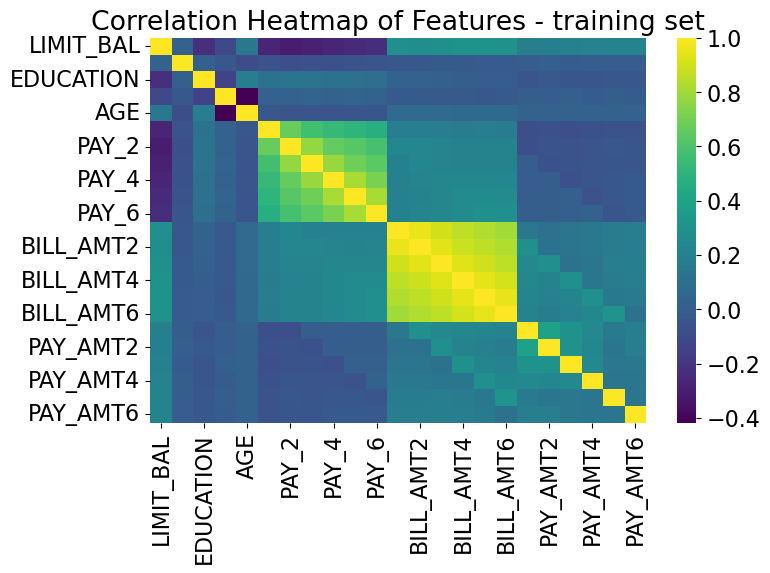

In [9]:
#set up the corr matrix
correlation_matrix = X_train.corr()

#matplot fig
plt.figure(figsize=(8,5))

#create heatmap
sns.heatmap(correlation_matrix, cmap="viridis")

plt.title("Correlation Heatmap of Features - training set")
plt.show()


In [10]:
"""
pay_x and bill_amtx have strong correlations amongst their own types, which suggest consistent behaviour patterns.
bill_amt & pay_amt have some correlation (as expected). I also see a corr between limit_bal and bill_amt.
bill_amt are usually close to each other. As well as pay_amt. 
payment statuses are also correlated with each other.

"""

'\npay_x and bill_amtx have strong correlations amongst their own types, which suggest consistent behaviour patterns.\nbill_amt & pay_amt have some correlation (as expected). I also see a corr between limit_bal and bill_amt.\nbill_amt are usually close to each other. As well as pay_amt. \npayment statuses are also correlated with each other.\n\n'

<Axes: xlabel='default.payment.next.month', ylabel='LIMIT_BAL'>

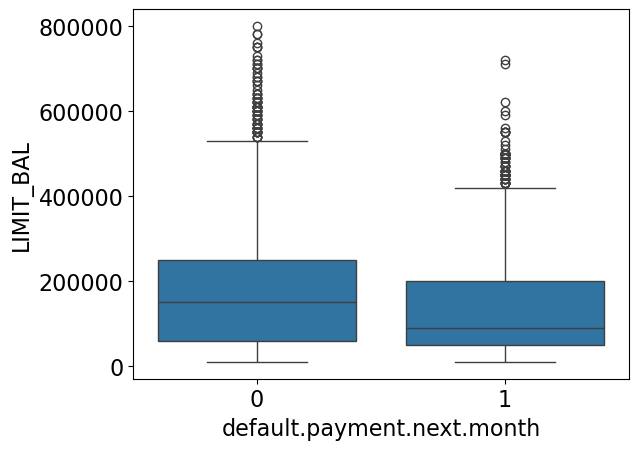

In [11]:
# boxplot of default.payment.next.month vs limit bal
sns.boxplot(x=y_train, y="LIMIT_BAL", data=X_train)

In [12]:
"""
the median of non-defaulters (0) LIMIT_bal is higher than defaulters (1), 
meaning clients with higher credit limits are less likely to default. But there is also class imbalance and plus
there's a considerable overlap between the boxes so LIMIT_bal might not be the strongest predictor.

"""

"\nthe median of non-defaulters (0) LIMIT_bal is higher than defaulters (1), \nmeaning clients with higher credit limits are less likely to default. But there is also class imbalance and plus\nthere's a considerable overlap between the boxes so LIMIT_bal might not be the strongest predictor.\n\n"

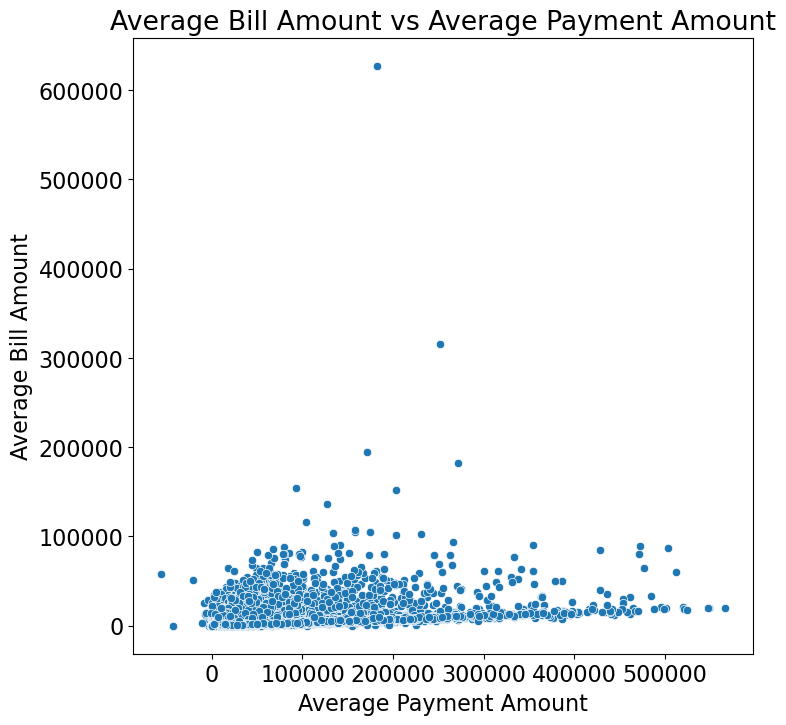

In [13]:
# scatter plotting rltnship between avg_payment_amt vs avg_bill_amt
# accumulating all the months under a new column for convenience
avg_bill_amt = X_train[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean(axis=1)
avg_payment_amt = X_train[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].mean(axis=1)
plt.figure(figsize=(8, 8))
sns.scatterplot(x=avg_bill_amt, y=avg_payment_amt)
plt.title("Average Bill Amount vs Average Payment Amount")
plt.xlabel("Average Payment Amount")
plt.ylabel("Average Bill Amount")
plt.show()

In [14]:
"""
as average payment increases, total bill amounts also tend to increase. There are also some outliers
 that might disrupt the model performance.
"""

'\nas average payment increases, total bill amounts also tend to increase. There are also some outliers\n\xa0that might disrupt the model performance.\n'

In [15]:
"""
observations:
1) imbalance in the target variable
2) non-defaulters generally have higher credit limit compared to defaulters
3) most clients have payment statuses around 0 or -1
4) higher limits often correspond to higher bills.
5) even tho the data descrip. doesn't mention the value "-2" for PAY_x, it is present in the dataset, 
 and it is quite large, so I will treat it as a distinct category for now. 
 The same issue persists in "Education" & "Marriage" (0's are present albeit not being described in the data desc.)
 these are way smaller anomalies in quantity, so they could be dropped.
6) there are some outliers which need to be filtered.

"""

'\nobservations:\n1) imbalance in the target variable\n2) non-defaulters generally have higher credit limit compared to defaulters\n3) most clients have payment statuses around 0 or -1\n4) higher limits often correspond to higher bills.\n5) even tho the data descrip. doesn\'t mention the value "-2" for PAY_x, it is present in the dataset, \n and it is quite large, so I will treat it as a distinct category for now. \n The same issue persists in "Education" & "Marriage" (0\'s are present albeit not being described in the data desc.)\n these are way smaller anomalies in quantity, so they could be dropped.\n6) there are some outliers which need to be filtered.\n\n'

In [16]:
"""
because there's class imbalance, accuracy won't be a reliable metric. Since this is a classification problem, I can go
with precision, recall, f1, AP score, or ROC-AUC. In my case, since I want to place an importance on false positives (to keep
our customers happy) and indirectly false negatives, so I will go with the AP score as my scoring.
"""

"\nbecause there's class imbalance, accuracy won't be a reliable metric. Since this is a classification problem, I can go\nwith precision, recall, f1, AP score, or ROC-AUC. In my case, since I want to place an importance on false positives (to keep\nour customers happy) and indirectly false negatives, so I will go with the AP score as my scoring.\n"

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 4. Feature engineering <a name="4"></a>
<hr>
rubric={points:1}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

<div class="alert alert-warning">
    
Solution_4
    
</div>

_Points:_ 1

In [17]:
#firstly, the avg bill amt column
bill_columns = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

X_train['avg_bill_amt'] = X_train[bill_columns].mean(axis=1)
X_test['avg_bill_amt'] = X_test[bill_columns].mean(axis=1)

#the average payment amt column
payment_columns = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

X_train['avg_payment_amt'] = X_train[payment_columns].mean(axis=1)
X_test['avg_payment_amt'] = X_test[payment_columns].mean(axis=1)

#create the 'bill_to_limit_ratio' feature in both X_train and X_test
X_train['bill_to_limit_ratio'] = X_train['avg_bill_amt'] / X_train['LIMIT_BAL']
X_test['bill_to_limit_ratio'] = X_test['avg_bill_amt'] / X_test['LIMIT_BAL']

#payment consistency (count of months where payment is made duly, i.e., PAY_X = -1)
X_train['consistent_payment_count'] = (X_train[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']] == -1).sum(axis=1)
X_test['consistent_payment_count'] = (X_test[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']] == -1).sum(axis=1)

#replacing 0 in avg_bill_amt with a small value (1e-6) to avoid division by zero. Help received by ChatGPT (prompt: how can I replace the 0 values with small values?)
X_train.update(X_train['avg_bill_amt'].replace(0, 1e-6))
X_test.update(X_test['avg_bill_amt'].replace(0, 1e-6))

#average payment amt to bill amt ratio.
X_train['avg_payment_to_avg_bill_ratio'] = X_train['avg_payment_amt'] / X_train['avg_bill_amt']
X_test['avg_payment_to_avg_bill_ratio'] = X_test['avg_payment_amt'] / X_test['avg_bill_amt']

#how many months did the client delay payment?
X_train['months_late_payment'] = (X_train[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']] > 0).sum(axis=1)
X_test['months_late_payment'] = (X_train[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']] > 0).sum(axis=1)

#higher repayment status values increase the "weight" of that bill.
X_train['weighted_bill_delay'] = (
    X_train['BILL_AMT1'] * X_train['PAY_0'] +
    X_train['BILL_AMT2'] * X_train['PAY_2'] +
    X_train['BILL_AMT3'] * X_train['PAY_3'] +
    X_train['BILL_AMT4'] * X_train['PAY_4'] +
    X_train['BILL_AMT5'] * X_train['PAY_5'] +
    X_train['BILL_AMT6'] * X_train['PAY_6']
) / 6

X_test['weighted_bill_delay'] = (
    X_test['BILL_AMT1'] * X_test['PAY_0'] +
    X_test['BILL_AMT2'] * X_test['PAY_2'] +
    X_test['BILL_AMT3'] * X_test['PAY_3'] +
    X_test['BILL_AMT4'] * X_test['PAY_4'] +
    X_test['BILL_AMT5'] * X_test['PAY_5'] +
    X_test['BILL_AMT6'] * X_test['PAY_6']
) / 6

#threshold for high bills, you might set this based on business context or mean bill amount (ChatGPT recommended feature)
high_bill_threshold = X_train[[f'BILL_AMT{i}' for i in range(1, 7)]].mean().mean()

# Count months with severe delays
X_train['severe_delay_count'] = (X_train[[f'PAY_{i}' for i in [0, 2, 3, 4, 5, 6]]] >= 3).sum(axis=1) 
X_test['severe_delay_count'] = (X_test[[f'PAY_{i}' for i in [0, 2, 3, 4, 5, 6]]] >= 3).sum(axis=1) 

# Count months with high bills
X_train['high_bill_count'] = (X_train[[f'BILL_AMT{i}' for i in range(1, 7)]] > high_bill_threshold).sum(axis=1)
X_test['high_bill_count'] = (X_test[[f'BILL_AMT{i}' for i in range(1, 7)]] > high_bill_threshold).sum(axis=1)




<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 5. Preprocessing and transformations <a name="5"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

<div class="alert alert-warning">
    
Solution_5
    
</div>

_Points:_ 10

In [18]:
#before dividing the features into their respective categories, I want to filter the minor discrepancies in "MARRIAGE" & "EDUCATION" described in the observations.

#clean X_train and y_train to keep only valid rows for MARRIAGE and EDUCATION
X_train_cleaned = X_train[(X_train['MARRIAGE'] != 0) & (X_train['EDUCATION'] != 0)]
y_train_cleaned = y_train[X_train_cleaned.index]  # Align y_train with cleaned X_train


X_test_cleaned = X_test[(X_test['MARRIAGE'] != 0) & (X_test['EDUCATION'] != 0)]
y_test_cleaned = y_test[X_test_cleaned.index]  # Align y_test with cleaned X_test

#now, I want to remove all the potential outliers before preprocessing. (Refined my function through ChatGPT)

def remove_outliers_iqr(X_train, y_train, columns, threshold=1.5):
    """
    Removes outliers from X_train based on IQR calculated from X_train.
    Ensures y_train aligns with X_train after outlier removal.

    Parameters:
    - X_train: DataFrame, training data
    - y_train: Series, target variable for training data 
    - columns: list of column names to check for outliers
    - threshold: float, the multiplier for IQR to set the outlier bounds

    Returns:
    - X_train_filtered: DataFrame with outliers removed
    - y_train_filtered: Series with corresponding rows removed
    """
    outlier_indices = set()

    # Calculate outlier indices for each column
    for column in columns:
        Q1 = X_train[column].quantile(0.25)
        Q3 = X_train[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define outlier bounds
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Find outlier indices
        outliers = X_train[(X_train[column] < lower_bound) | (X_train[column] > upper_bound)].index
        outlier_indices.update(outliers)

    # Drop outliers from X_train and y_train using the combined set of indices
    X_train_filtered = X_train.drop(index=outlier_indices)
    y_train_filtered = y_train.drop(index=outlier_indices)

    return X_train_filtered, y_train_filtered

# Define columns to clean
outlier_columns = ['LIMIT_BAL', 'avg_bill_amt', 'avg_payment_amt']

# Run the outlier removal function
X_train_filtered, y_train_filtered = remove_outliers_iqr(X_train_cleaned, y_train_cleaned, outlier_columns)

print(X_train_cleaned.shape[0])
print(y_train_cleaned.shape[0])

print(X_train_filtered.shape[0])
print(y_train_filtered.shape[0])



17961
17961
15021
15021


In [19]:

# I am dropping these features to reduce multicollinearity since they were used to construct the new features.
drop_features = ['BILL_AMT1', 
                      'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 
                      'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 
                      'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

#numerical features
numerical_features = ['LIMIT_BAL', 'AGE', 'avg_bill_amt', 'avg_payment_amt', 
                      'bill_to_limit_ratio', 'consistent_payment_count', 
                      'avg_payment_to_avg_bill_ratio', 'weighted_bill_delay', 'severe_delay_count',
                      'high_bill_count']

#ordinal features
ordinal_features = ['EDUCATION']
#sex is accepted as binary only for the sake of easier categorization.
binary_features = ['SEX']
#classifying PAY_x and hence severe_delay_count as categorical since the numbers represent distinct
# categories, rather than continuous values.
categorical_features = ['MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

numeric_transformer = StandardScaler()

ordinal_transformer = OrdinalEncoder(dtype=int)

binary_transformer = OneHotEncoder(drop="if_binary", dtype=int, handle_unknown="ignore")

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = make_column_transformer(
    (numeric_transformer, numerical_features),
    (ordinal_transformer, ordinal_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features),
)


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 6. Baseline model <a name="6"></a>
<hr>
rubric={points:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

<div class="alert alert-warning">
    
Solution_6
    
</div>

_Points:_ 2

In [20]:
dummy = DummyClassifier(random_state=123)
dummy_pipe = make_pipeline(preprocessor, dummy)

#applying cv, 
cv_result = cross_validate(dummy_pipe, X_train_cleaned, y_train_cleaned, cv=5, return_train_score=True)

dummy_cv_df = pd.DataFrame(cv_result)
display(dummy_cv_df)

#applying cv, but this time the scoring is AP score since that was the metric I picked in the beginning.
cv_result_ap = cross_validate(dummy_pipe, X_train_cleaned, y_train_cleaned, cv=5, scoring='average_precision', return_train_score=True)

dummy_cv_ap_df = pd.DataFrame(cv_result_ap)
display(dummy_cv_ap_df)



,fit_time,score_time,test_score,train_score
0,0.090611,0.026317,0.777067,0.777283
1,0.079612,0.028337,0.777283,0.777229
2,0.099977,0.042909,0.777283,0.777229
3,0.059017,0.020782,0.777283,0.777229
4,0.074065,0.017331,0.777283,0.777229


,fit_time,score_time,test_score,train_score
0,0.061962,0.022594,0.222933,0.222717
1,0.071181,0.037781,0.222717,0.222771
2,0.134414,0.021759,0.222717,0.222771
3,0.059780,0.024648,0.222717,0.222771
4,0.145592,0.106497,0.222717,0.222771


In [21]:
#because there is class imbalance, the accuracy is unusually high for a dummy model. hence accuracy is not a good metric here
# and we will use "ap score" as our scoring.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 7. Linear models <a name="7"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Try a linear model as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the complexity hyperparameter. 
3. Report cross-validation scores along with standard deviation. 
4. Summarize your results.

<div class="alert alert-warning">
    
Solution_7
    
</div>

_Points:_ 10

_Type your answer here, replacing this text._

In [22]:
#creating LogisticRegression
lr = LogisticRegression(random_state=123, max_iter=500)

#pipeline
lr_pipe = make_pipeline(preprocessor, lr)

In [23]:
#define the hyperparameters for tuning
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100,1000]}

#set up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(lr_pipe, param_grid, cv=5, scoring='average_precision', return_train_score=True)

In [24]:
grid_search.fit(X_train_filtered, y_train_filtered)

#get cross-validation results
cv_results = pd.DataFrame(grid_search.cv_results_)

#display best hyperparameters and cross-validation scores
print("Best hyperparameter:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

#display cv results with standard deviation
cv_results[['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'param_logisticregression__C']]

Best hyperparameter: {'logisticregression__C': 0.1}
Best cross-validation score: 0.5642015000833475


,mean_test_score,std_test_score,mean_train_score,std_train_score,param_logisticregression__C
0,0.555064,0.014941,0.559044,0.003832,0.01
1,0.564202,0.015156,0.572263,0.003894,0.10
2,0.563910,0.014261,0.577189,0.003671,1.00
3,0.561192,0.014988,0.578367,0.003809,10.00
4,0.559778,0.014937,0.579003,0.003402,100.00
5,0.560269,0.014838,0.579407,0.003471,1000.00


In [25]:
#it seems like our best cv result is ~0.55 which is higher than our dummy model but pretty low overall.
# the sd's are pretty small so the variation isn't huge.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 8. Different models <a name="8"></a>
<hr>
rubric={points:12}

**Your tasks:**
1. Try at least 3 other models aside from a linear model. One of these models should be a tree-based ensemble model. 
2. Summarize your results in terms of overfitting/underfitting and fit and score times. Can you beat a linear model? 

<div class="alert alert-warning">
    
Solution_8
    
</div>

_Points:_ 12

_Type your answer here, replacing this text._

In [26]:
#svm model 

svm_model = SVC(random_state=123)

#pipeline
pipe_svm = make_pipeline(preprocessor, svm_model)

#perform cross-validation using AP score
cv_svm = cross_validate(pipe_svm, X_train_filtered, y_train_filtered, cv=5, return_train_score=True, scoring='average_precision')

svm_cv_df = pd.DataFrame(cv_svm)

print(svm_cv_df)

    fit_time  score_time  test_score  train_score
0  17.224706    3.699496    0.529500     0.650659
1  14.775774    1.294743    0.521306     0.650491
2  17.524763    1.404011    0.550802     0.647455
3  15.930751    1.482699    0.548733     0.646680
4  12.314645    1.213351    0.537328     0.649648


In [27]:
#random forest classifier (ensemble model)

rfc = RandomForestClassifier(n_jobs=-1,random_state=123, class_weight='balanced')

#pipeline
pipe_rfc = make_pipeline(preprocessor, rfc)

#perform cv using AP score
cv_rfc = cross_validate(pipe_rfc, X_train_filtered, y_train_filtered, cv=5, return_train_score=True, scoring='average_precision')

rfc_cv_df = pd.DataFrame(cv_rfc)

print(rfc_cv_df)

   fit_time  score_time  test_score  train_score
0  4.393866    0.073768    0.542917     0.999975
1  4.404981    0.075118    0.545814     0.999871
2  3.887742    0.075206    0.556087     0.999855
3  3.633538    0.073169    0.543927     0.999763
4  3.675552    0.078879    0.537305     0.999880


In [28]:
#lightGBM model
lgbm_model = LGBMClassifier(random_state=123, class_weight='balanced')

#pipeline
pipe_lgbm = make_pipeline(preprocessor, lgbm_model)

#perform cv using AP score
cv_lgbm = cross_validate(pipe_lgbm, X_train_filtered, y_train_filtered, cv=5, return_train_score=True, scoring='average_precision')

lgbm_cv_df = pd.DataFrame(cv_lgbm)

print(lgbm_cv_df)

[LightGBM] [Info] Number of positive: 2852, number of negative: 9164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1499
[LightGBM] [Info] Number of data points in the train set: 12016, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 2852, number of negative: 9165
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1498
[LightGBM] [Info] Number of data points in the train set: 12017, number of used features: 55
[LightGBM] [Info] [binar

In [29]:
#overall there is quite a bit of overfitting occurring in random forest classifier. and some occurring in lightgbm.
#the test scores are roughly in the same range as the logistic regression model, although the parameters of these non-linear models are not hypertuned.
#lightgbm has the best results out of all tho.
#svm's fit time is the highest by far. after that random tree forest takes the second place and lastly lightgbm as the fastest model.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 9. Feature selection <a name="9"></a>
<hr>
rubric={points:2}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV` or forward selection for this. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

<div class="alert alert-warning">
    
Solution_9
    
</div>

_Points:_ 2

_Type your answer here, replacing this text._

In [30]:
# creating RFECV with LR instead of a non-linear model bc of computational limitations
rfe_cv = RFECV(LogisticRegression(max_iter=2000), step=2, cv=10, scoring='average_precision')


X_train_transformed = preprocessor.fit_transform(X_train_filtered)
X_test_transformed = preprocessor.transform(X_test_cleaned)

rfe_cv.fit(X_train_transformed, y_train_filtered)

RFECV(cv=10, estimator=LogisticRegression(max_iter=2000),
      scoring='average_precision', step=2)

In [31]:
# Display results
print("Optimal number of features:", rfe_cv.n_features_)
selected_feature_indices = [i for i, support in enumerate(rfe_cv.support_) if support]
print("Selected feature indices:", selected_feature_indices)

# get feature names from the ColumnTransformer
feature_names = preprocessor.get_feature_names_out()

# get the names of selected features based on RFECV's support_
selected_feature_names = feature_names[rfe_cv.support_]
print("Selected Features:", list(selected_feature_names))

Optimal number of features: 38
Selected feature indices: [0, 3, 4, 5, 11, 13, 14, 15, 16, 17, 19, 20, 25, 27, 29, 32, 33, 36, 37, 41, 42, 46, 51, 53, 54, 55, 59, 60, 61, 62, 64, 65, 66, 68, 70, 72, 75, 77]
Selected Features: ['standardscaler__LIMIT_BAL', 'standardscaler__avg_payment_amt', 'standardscaler__bill_to_limit_ratio', 'standardscaler__consistent_payment_count', 'onehotencoder-1__SEX_2', 'onehotencoder-2__MARRIAGE_2', 'onehotencoder-2__MARRIAGE_3', 'onehotencoder-2__PAY_0_-2', 'onehotencoder-2__PAY_0_-1', 'onehotencoder-2__PAY_0_0', 'onehotencoder-2__PAY_0_2', 'onehotencoder-2__PAY_0_3', 'onehotencoder-2__PAY_0_8', 'onehotencoder-2__PAY_2_-1', 'onehotencoder-2__PAY_2_1', 'onehotencoder-2__PAY_2_4', 'onehotencoder-2__PAY_2_5', 'onehotencoder-2__PAY_2_8', 'onehotencoder-2__PAY_3_-2', 'onehotencoder-2__PAY_3_2', 'onehotencoder-2__PAY_3_3', 'onehotencoder-2__PAY_3_7', 'onehotencoder-2__PAY_4_2', 'onehotencoder-2__PAY_4_4', 'onehotencoder-2__PAY_4_5', 'onehotencoder-2__PAY_4_6', 'on

In [32]:
# Define models with pipelines including the preprocessor, RFECV, and non-linear model
models_with_feature_selection = {
    "SVM (Selected Features)": Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', rfe_cv),
        ('classifier', SVC(probability=True, random_state=123))
    ]),
    "Random Forest (Selected Features)": Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', rfe_cv),
        ('classifier', RandomForestClassifier(n_jobs=-1, random_state=123, class_weight='balanced'))
    ]),
    "LightGBM (Selected Features)": Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', rfe_cv),
        ('classifier', LGBMClassifier(random_state=123, class_weight='balanced'))
    ])
}

# Dictionary to store cross-validation results
cv_results_selected = {}

# Cross-validate each model in the pipeline, using average precision as the scoring metric
scoring = make_scorer(average_precision_score, needs_proba=True)
for model_name, pipeline in models_with_feature_selection.items():
    cv = cross_validate(pipeline, X_train_filtered, y_train_filtered, cv=5, return_train_score=True, scoring=scoring)
    cv_results_selected[model_name] = {
        "Mean Train AP": cv["train_score"].mean(),
        "Std Train AP": cv["train_score"].std(),
        "Mean Test AP": cv["test_score"].mean(),
        "Std Test AP": cv["test_score"].std()
    }

# Convert results to a DataFrame for comparison
cv_results_selected_df = pd.DataFrame(cv_results_selected).T
print(cv_results_selected_df)



/opt/miniconda3/envs/cpsc330/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2852, number of negative: 9164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.164655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 617
[LightGBM] [Info] Number of data points in the train set: 12016, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 2852, number of negative: 9165
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1241
[LightGBM] [Info] Number of data points in the train set: 12017, number of used features: 53
[LightGBM] [Info] [binary

In [33]:
"""
Overall the scores aren't far away from the baseline nonlinear models with feature selection,
which indicates that while complex models capture training patterns well,
they still struggle with test generalization. I will try hyperparameter optimization to see
if there are any amendments we can make. LightGBM is relatively the best model we currently have right now.
"""

"\nOverall the scores aren't far away from the baseline nonlinear models with feature selection,\nwhich indicates that while complex models capture training patterns well,\nthey still struggle with test generalization. I will try hyperparameter optimization to see\nif there are any amendments we can make. LightGBM is relatively the best model we currently have right now.\n"

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 10. Hyperparameter optimization <a name="10"></a>
<hr>
rubric={points:10}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. In at least one case you should be optimizing multiple hyperparameters for a single model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize) 

<div class="alert alert-warning">
    
Solution_10
    
</div>

_Points:_ 10

_Type your answer here, replacing this text._

In [34]:
# So far the most promising model has been LightGBM. I will perform my hyperparameter tuning on it first.
#define parameter grids distribution, I will first use RandomizedSearchCV, then refine the best hyperparameters with GridSearch.
lgbm_param_grid = {
    'lgbmclassifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'lgbmclassifier__num_leaves': [20, 31, 40, 50],
    'lgbmclassifier__max_depth': [-1, 10, 20, 30],
    'lgbmclassifier__min_child_samples': [5, 10, 20],
}

pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123, class_weight='balanced'))

#run RandomizedSearchCV for LightGBM
random_search = RandomizedSearchCV(
    pipe_lgbm,
    param_distributions=lgbm_param_grid,
    n_iter=20,  # Number of random parameter combinations
    scoring='average_precision',
    cv=5,
    random_state=123,
    n_jobs=-1
)

random_search.fit(X_train_filtered, y_train_filtered)


    

[LightGBM] [Info] Number of positive: 3565, number of negative: 11456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1513
[LightGBM] [Info] Number of data points in the train set: 15021, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['LIMIT_BAL',
                                                                                'AGE',
                                                                                'avg_bill_amt',
                                                                                'avg_payment_amt',
                                                                                'bill_to_limit_ratio',
                                                                                'consistent_payment_count',
                                                                                'avg_payment_to_avg_bill_ratio',
                                                                                'weighted_bill_delay',
                                                                                'severe_delay_count',
                                                                                'high_bill_count']),
                                                                              ('ordinalencoder...
                                                                                'PAY_AMT6'])])),
                                             ('lgbmclassifier',
                                              LGBMClassifier(class_weight='balanced',
                                                             random_state=123))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'lgbmclassifier__learning_rate': [0.01,
                                                                          0.05,
                                                                          0.1,
                                                                          0.2],
                                        'lgbmclassifier__max_depth': [-1, 10,
                                                                      20, 30],
                                        'lgbmclassifier__min_child_samples': [5,
                                                                              10,
                                                                              20],
                                        'lgbmclassifier__num_leaves': [20, 31,
                                                                       40,
                                                                       50]},
                   random_state=123, scoring='average_precision')

In [35]:
#output best parameters and performance
print("Best Parameters from RandomizedSearchCV for LightGBM:")
print(random_search.best_params_)
print(f"Best Average Precision Score: {random_search.best_score_:.4f}")

Best Parameters from RandomizedSearchCV for LightGBM:
{'lgbmclassifier__num_leaves': 20, 'lgbmclassifier__min_child_samples': 10, 'lgbmclassifier__max_depth': 30, 'lgbmclassifier__learning_rate': 0.05}
Best Average Precision Score: 0.5775


In [36]:
#now, I will perform GridSearchCV on a refined set of parameters based on results from RandomizedSearchCV
lgbm_refined_param_grid = {
    'lgbmclassifier__learning_rate': [random_search.best_params_['lgbmclassifier__learning_rate']],
    'lgbmclassifier__num_leaves': [random_search.best_params_['lgbmclassifier__num_leaves'] - 10, 
                               random_search.best_params_['lgbmclassifier__num_leaves'], 
                               random_search.best_params_['lgbmclassifier__num_leaves'] + 10],
    'lgbmclassifier__max_depth': [random_search.best_params_['lgbmclassifier__max_depth']],
}

grid_search = GridSearchCV(
    pipe_lgbm,
    param_grid=lgbm_refined_param_grid,
    scoring='average_precision',
    cv=5,
    n_jobs=-1
)


grid_search.fit(X_train_filtered, y_train_filtered)

#the best parameters and performance
print("Best Parameters from GridSearchCV for LightGBM:")
print(grid_search.best_params_)
print(f"Best Average Precision Score: {grid_search.best_score_:.4f}")

[LightGBM] [Info] Number of positive: 3565, number of negative: 11456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1501
[LightGBM] [Info] Number of data points in the train set: 15021, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Best Parameters from GridSearchCV for LightGBM:
{'lgbmclassifier__learning_rate': 0.05, 'lgbmclassifier__max_depth': 30, 'lgbmclassifier__num_leaves': 20}
Best Average Precision Score: 0.5792


In [37]:
# Now I'm going to hyperparameter tune the second best model we have.
#define parameter grid for RandomForest
rfc_param_grid = {
    'randomforestclassifier__n_estimators': [50, 100, 200, 500, 1000],
    'randomforestclassifier__max_depth': [None, 10, 20, 30],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
    'randomforestclassifier__max_features': ['sqrt', 'log2']
}

pipe_rfc = make_pipeline(preprocessor, RandomForestClassifier(n_jobs=-1, random_state=123, class_weight='balanced'))

#run RandomizedSearchCV for RandomForest
random_search_rfc = RandomizedSearchCV(
    pipe_rfc,
    param_distributions=rfc_param_grid,
    n_iter=25,
    scoring='average_precision',
    cv=5,
    random_state=123,
    n_jobs=-1
)

#fit the random search
random_search_rfc.fit(X_train_filtered, y_train_filtered)

# Output best parameters and performance
print("Best Parameters from RandomizedSearchCV for Random Forest:")
print(random_search_rfc.best_params_)
print(f"Best Average Precision Score: {random_search_rfc.best_score_:.4f}")

Best Parameters from RandomizedSearchCV for Random Forest:
{'randomforestclassifier__n_estimators': 1000, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 10}
Best Average Precision Score: 0.5775


In [38]:
"""
Both models reach a similar AP score of ~0.58. 

LightGBM has a lower learning rate and a moderate depth and number of leaves,
whereas Random Forest has a high no of estimators, increased min samples for splits and leaves.

"""

'\nBoth models reach a similar AP score of ~0.58. \n\nLightGBM has a lower learning rate and a moderate depth and number of leaves,\nwhereas Random Forest has a high no of estimators, increased min samples for splits and leaves.\n\n'

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 11. Interpretation and feature importances <a name="1"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Use the methods we saw in class (e.g., `shap`) (or any other methods of your choice) to examine the most important features of one of the non-linear models. 
2. Summarize your observations. 

<div class="alert alert-warning">
    
Solution_11
    
</div>

_Points:_ 10

_Type your answer here, replacing this text._

In [39]:
import shap

#fit the best LightGBM model on the entire training data
best_lgbm = LGBMClassifier(
    random_state=123, 
    class_weight='balanced', 
    learning_rate=0.05, 
    max_depth=30, 
    num_leaves=20
)

pipe_lgbm = make_pipeline(preprocessor, best_lgbm)
pipe_lgbm.fit(X_train_filtered, y_train_filtered)

[LightGBM] [Info] Number of positive: 3565, number of negative: 11456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1501
[LightGBM] [Info] Number of data points in the train set: 15021, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['LIMIT_BAL', 'AGE',
                                                   'avg_bill_amt',
                                                   'avg_payment_amt',
                                                   'bill_to_limit_ratio',
                                                   'consistent_payment_count',
                                                   'avg_payment_to_avg_bill_ratio',
                                                   'weighted_bill_delay',
                                                   'severe_delay_count',
                                                   'high_bill_count']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(dtype=<class 'int'...
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['MARRIAGE', 'PAY_0', 'PAY_2',
                                                   'PAY_3', 'PAY_4', 'PAY_5',
                                                   'PAY_6']),
                                                 ('drop', 'drop',
                                                  ['BILL_AMT1', 'BILL_AMT2',
                                                   'BILL_AMT3', 'BILL_AMT4',
                                                   'BILL_AMT5', 'BILL_AMT6',
                                                   'PAY_AMT1', 'PAY_AMT2',
                                                   'PAY_AMT3', 'PAY_AMT4',
                                                   'PAY_AMT5', 'PAY_AMT6'])])),
                ('lgbmclassifier',
                 LGBMClassifier(class_weight='balanced', learning_rate=0.05,
                                max_depth=30, num_leaves=20,
                                random_state=123))])

In [40]:
X_train_transformed=preprocessor.transform(X_train_filtered)
explainer = shap.TreeExplainer(best_lgbm, data=X_train_transformed.toarray(), feature_names=X_train_filtered.columns)


In [57]:
shap_values = explainer.shap_values(X_train_transformed.toarray(), check_additivity=False)



 99%|===================| 14893/15021 [00:48<00:00]        

[LightGBM] [Info] Number of positive: 2852, number of negative: 9164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1509
[LightGBM] [Info] Number of data points in the train set: 12016, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 2852, number of negative: 9165
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1519
[LightGBM] [Info] Number of data points in the train set: 12017, number of used features: 66
[LightGBM] [Info] [binar

(15021, 78)
(15021, 32)


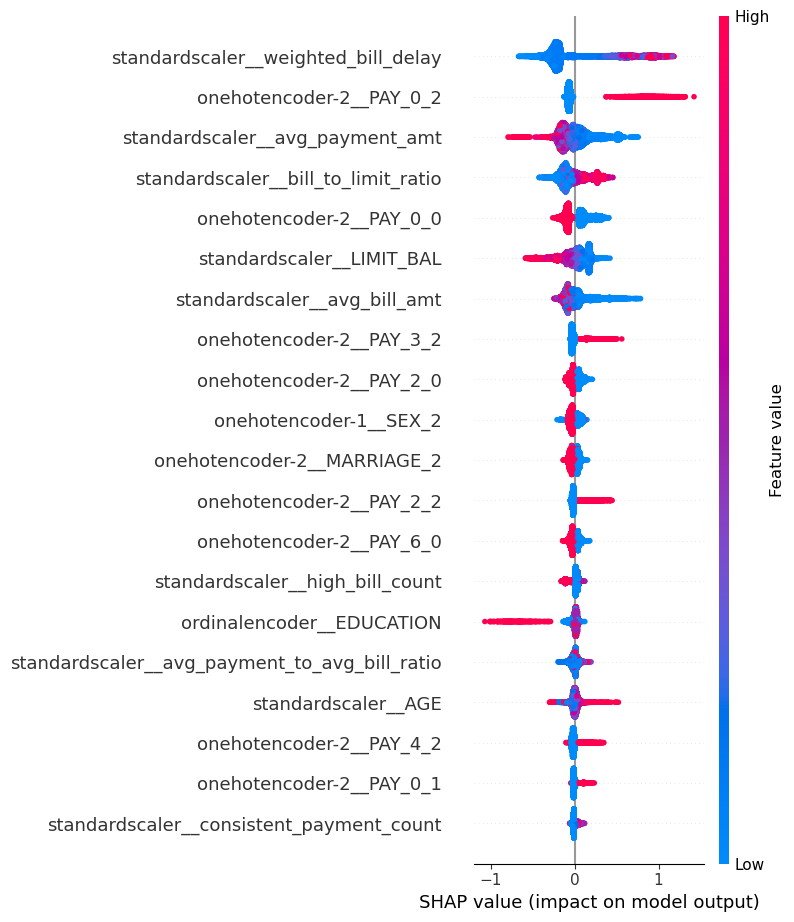

In [42]:
#this step was ChatGPT's suggestion for the errors that popped up.
print(X_train_transformed.shape)
print(X_train_filtered.shape)

# Step 1: Convert transformed data to dense DataFrame
X_train_dense = pd.DataFrame(X_train_transformed.toarray(), columns=preprocessor.get_feature_names_out())

# Step 2: Run shap summary plot with correctly labeled DataFrame
shap.summary_plot(shap_values, X_train_dense, feature_names=X_train_dense.columns)


In [43]:
""" 
Seems like weighted_bill_delay has the highest impact, followed by avg_payment_amt, 
some of the PAY_X columns, LIMIT_BAL, avg_bill_amt, EDUCATION, and AGE.

In summary, financial metrics related to payment behaviors and credit usage are critical predictors in the model, 
while demographic and categorical variables like SEX, MARRIAGE, and EDUCATION have less pronounced
but still notable effects.

"""

' \nSeems like weighted_bill_delay has the highest impact, followed by avg_payment_amt, \nsome of the PAY_X columns, LIMIT_BAL, avg_bill_amt, EDUCATION, and AGE.\n\nIn summary, financial metrics related to payment behaviors and credit usage are critical predictors in the model, \nwhile demographic and categorical variables like SEX, MARRIAGE, and EDUCATION have less pronounced\nbut still notable effects.\n\n'

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 12. Results on the test set <a name="12"></a>
<hr>

rubric={points:10}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 
3. Take one or two test predictions and explain these individual predictions (e.g., with SHAP force plots).  

<div class="alert alert-warning">
    
Solution_12
    
</div>

_Points:_ 10

_Type your answer here, replacing this text._

In [44]:
# The best performing model amongst our models is LightGBM, so I will deploy that model.

In [45]:
best_lgbm = LGBMClassifier(
    random_state=123, 
    class_weight='balanced', 
    learning_rate=0.05, 
    max_depth=30, 
    num_leaves=20
)

pipe_lgbm = make_pipeline(preprocessor, best_lgbm)
pipe_lgbm.fit(X_train_filtered, y_train_filtered)

[LightGBM] [Info] Number of positive: 3565, number of negative: 11456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1501
[LightGBM] [Info] Number of data points in the train set: 15021, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['LIMIT_BAL', 'AGE',
                                                   'avg_bill_amt',
                                                   'avg_payment_amt',
                                                   'bill_to_limit_ratio',
                                                   'consistent_payment_count',
                                                   'avg_payment_to_avg_bill_ratio',
                                                   'weighted_bill_delay',
                                                   'severe_delay_count',
                                                   'high_bill_count']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(dtype=<class 'int'...
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['MARRIAGE', 'PAY_0', 'PAY_2',
                                                   'PAY_3', 'PAY_4', 'PAY_5',
                                                   'PAY_6']),
                                                 ('drop', 'drop',
                                                  ['BILL_AMT1', 'BILL_AMT2',
                                                   'BILL_AMT3', 'BILL_AMT4',
                                                   'BILL_AMT5', 'BILL_AMT6',
                                                   'PAY_AMT1', 'PAY_AMT2',
                                                   'PAY_AMT3', 'PAY_AMT4',
                                                   'PAY_AMT5', 'PAY_AMT6'])])),
                ('lgbmclassifier',
                 LGBMClassifier(class_weight='balanced', learning_rate=0.05,
                                max_depth=30, num_leaves=20,
                                random_state=123))])

In [46]:
y_test_proba = pipe_lgbm.predict_proba(X_test_cleaned)[:, 1]

In [47]:
test_score = average_precision_score(y_test_cleaned, y_test_proba)

print(test_score)

0.5409280883492684


In [48]:
# the test score agrees with the poor validation scores from before.

In [49]:
# there is definitely some overfitting present. The training scores, albeit not being great, are still higher than the validation and test scores.
# I don't think there is optimization bias present since the validation scores are already really low.

In [50]:
# I would NOT trust this model, the low test score indicates that more complex models (DNNs, etc...) are required to capture the essence of the relationship.

In [51]:
#random test prediction idx to investigate.
ex1_idx = 3405

X_test_cleaned.iloc[ex1_idx]


LIMIT_BAL                        150000.000000
SEX                                   2.000000
EDUCATION                             1.000000
MARRIAGE                              2.000000
AGE                                  25.000000
PAY_0                                 0.000000
PAY_2                                 0.000000
PAY_3                                 0.000000
PAY_4                                 0.000000
PAY_5                                -1.000000
PAY_6                                 0.000000
BILL_AMT1                        150562.000000
BILL_AMT2                        148689.000000
BILL_AMT3                        147296.000000
BILL_AMT4                        144927.000000
BILL_AMT5                         54116.000000
BILL_AMT6                          6072.000000
PAY_AMT1                           5196.000000
PAY_AMT2                           3171.000000
PAY_AMT3                           3699.000000
PAY_AMT4                          69245.000000
PAY_AMT5     

In [52]:
y_test_cleaned.iloc[ex1_idx]

0

In [53]:
#non-defaulter

In [54]:
pipe_lgbm.predict(X_test_cleaned)[ex1_idx]

0

In [55]:
pipe_lgbm.predict_proba(X_test_cleaned)[ex1_idx]

array([0.80622646, 0.19377354])

 99%|===================| 11804/11971 [00:36<00:00]        

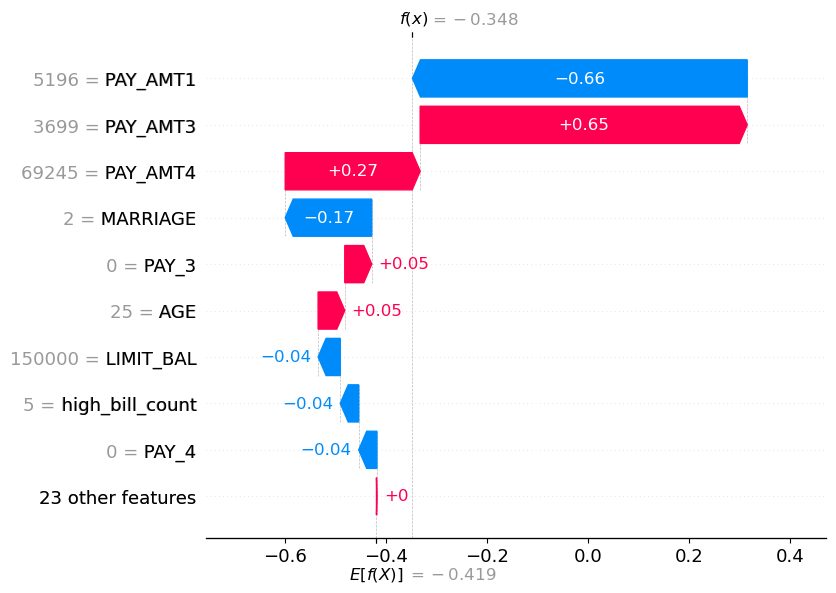

In [56]:
test_shap_values = explainer(X_test_cleaned, check_additivity=False)
shap.plots.waterfall(test_shap_values[ex1_idx])

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 13. Summary of results <a name="13"></a>
<hr>
rubric={points:12}

Imagine that you want to present the summary of these results to your boss and co-workers. 

**Your tasks:**

1. Create a table summarizing important results. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 
3. Report your final test score along with the metric you used at the top of this notebook in the [Submission instructions section](#si).

<div class="alert alert-warning">
    
Solution_13
    
</div>

_Points:_ 12

| Model                        | Cross-Validation Mean AP Score | Cross-Validation Std AP | Final Test AP Score | Key Hyperparameters      |
|------------------------------|--------------------------------|--------------------------|----------------------|--------------------------|
| Logistic Regression  (Tuned)         | 0.56                          | 0.02                     | -                    | C = 0.1                  |
| Random Forest (Tuned)        | 0.58                        | 0.02                     | -               | max_depth=10, n_estimators=1000 max_features= 'sqrt' min_samples_leaf= 4 |
| LightGBM (Tuned)             | 0.58                        | 0.01                     | 0.54               | max_depth=30, learning_rate=0.05, num_leaves=20 |
| Dummy Classifier             | 0.22                           | 0.00                     | -                    | -                        |


The results displayed show us that the model has not fully succeeded in "comprehending" the relationship between X and Y. I
believe that this is partly due to the state of the input data. My main conclusion is that there could be improvements in two directions:
1. cleaning all the data points that are not elaborated in the data description.
2. using a deep learning model to capture the complicated rltnshp between the features.

Additionally, I tried switching the feature types of "PAY_x" to see if that would improve the cv scores but that didn't change anything. Feature engineering was sufficient in my opinion, I strongly believe that the raw data might need some more advanced and in depth cleaning.

<!-- END QUESTION -->

<br><br>

<br><br>

<!-- BEGIN QUESTION -->

## 14. Your takeaway <a name="15"></a>
<hr>
rubric={points:2}

**Your tasks:**

What is your biggest takeaway from the supervised machine learning material we have learned so far? Please write thoughtful answers.  

<div class="alert alert-warning">
    
Solution_14
    
</div>

_Points:_ 2

I believe that the main takeaway for me was how the datasets in the real world are far from perfect and we will need our hands to get dirty. I truly spent most of my time exploring and cleaning the dataset.

<!-- END QUESTION -->

<br><br>

**PLEASE READ BEFORE YOU SUBMIT:** 

When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
4. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
5. Make sure that the plots and output are rendered properly in your submitted file. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb so that the TAs can view your submission on Gradescope. 

This was a tricky one but you did it! 

![](img/eva-well-done.png)